## Predicting Cell-cycle Information from Morphodynamic Features using Linear Regressors 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-09-10 11:53:46.836621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 11:54:01.471637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LassoCV

In [3]:
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [4]:
fovs = ['A2_1', 'A2_2', 'A2_3', 'B2_1', 'B2_3', 'B2_4']
nfovs = len(fovs)
pathSet = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)

In [5]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [6]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_3.obj with 58579 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_1.obj with 67836 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_3.obj with 57884 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_4.obj with 46096 cells


In [7]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [8]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [9]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [10]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [11]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [12]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [13]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell

In [14]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory 
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

## Load Cell Features & Labels Extracted from O2VAE (https://github.com/directysj/o2vae.git)

In [15]:
latent_dim=256 # Latent (Bottleneck) Dimension of Variational Auto-encoder 
for i in indgood_models:
    data_vae = np.load(f'../o2vae/features_vae{latent_dim}_{sysName[:-1]}{fovs[i]}.npz')
    features_vae = data_vae['embeddings']
    #labels_vae = data_vae['labels']
    modelSet[i].Xf_vae = features_vae
    #cell2cell_interaction_features = modelSet[i].Xf[:, 77:]
    #modelSet[i].Xf_new = np.concatenate((modelSet[i].Xf_vae, cell2cell_interaction_features), axis=1)

## Featurized Single-cell Trajectories

In [16]:
trajectory_lengths = np.array([1, 4, 8, 20, 40])

In [17]:
trajl = trajectory_lengths[0]
print(f"Generating trajectories of snippet length: {trajl}")
#Xf_traj = np.zeros((0, (modelSet[0].Xf_new.shape[1]+n_COMfeatures)*trajl))
Xf_traj = np.zeros((0, modelSet[0].Xf_vae.shape[1]*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    #data = modelSet[i].Xf[modelSet[i].traj, :] 
    data = modelSet[i].Xf_vae[modelSet[i].traj, :]
    #datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    #data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf.shape[1]*trajl)
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_vae.shape[1]*trajl)
    #datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    #data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Generating trajectories of snippet length: 1
Building trajectory data for model: 0
Building trajectory data for model: 1
Building trajectory data for model: 2
Building trajectory data for model: 3
Building trajectory data for model: 4
Building trajectory data for model: 5


In [18]:
def get_cellCycInfoTrajs(file_info):
    with open(file_info, 'r') as fp:
        lines = fp.readlines()

    nuc2cytoRatio = []
    CC_vals = []
    frames = []

    for line1, line2, line3 in zip(lines[::3], lines[1::3], lines[2::3]):
        line1 = np.array(line1.strip()[1:-1].split(', '), dtype=float)
        line2 = np.array(line2.strip()[1:-1].split(', '), dtype=float)
        line3 = np.array(line3.strip()[1:-1].split(', '), dtype=int)

        mask = ~np.isnan(line1)
        line1 = line1[mask]
        line2 = line2[mask]
        line3 = line3[mask]

        nuc2cytoRatio.append(line1) # Nuclear/Cytoplasm Ratio
        CC_vals.append(line2) # Cross-correlation between cell-cycle & Nuclear Reporters
        frames.append(line3) # Frame Numbers Along the Single-cell Trajectories 

    return nuc2cytoRatio, CC_vals, frames

In [19]:
file_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/cellCycInfoRawReporterImgs/'
sname_reporter = "LI204601_G"

In [20]:
X = [None] * nfovs
y = [None] * nfovs

for i in range(nfovs):
    # Get cross-correlation values along all single-cell trajectories  
    cc_filename = f"{file_path}{sname_reporter}_{fovs[i]}.dat"
    n2c_ratio, cc_vals, frame_numbers = get_cellCycInfoTrajs(cc_filename)

    valid_indstm = []
    cc_vals_last_frames = []
    model_indc = i
    indstm = np.where(indtreatment_traj == model_indc)[0]
    fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
    indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
    
    for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
        # Look for a snippet frame within its full trajectory
        possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])[0]
        if len(possible_indices) > 0:
            cc_values = cc_vals[ind_fulltraj][possible_indices[0]]
            cc_vals_last_frames.append(cc_values)
            valid_indstm.append(indstm[j]) 
         
    cc_vals_last_frames = np.array(cc_vals_last_frames)
    X[i] = Xf_traj[valid_indstm]  # Use the valid indices to index into Xf_traj
    y[i] = cc_vals_last_frames
    print(f"Preparing data of {fovs[i]} field of view.")

Preparing data of A2_1 field of view.
Preparing data of A2_2 field of view.
Preparing data of A2_3 field of view.
Preparing data of B2_1 field of view.
Preparing data of B2_3 field of view.
Preparing data of B2_4 field of view.


## Leaving One (FOV) Out Cross Validations

In [21]:
def trim_cc_vals(cc_values, num_bins, target_density):
    df = pd.DataFrame(cc_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

## Training on all 'A' wells & Testing on 'B' wells using Linear Regression

<Figure size 640x480 with 0 Axes>

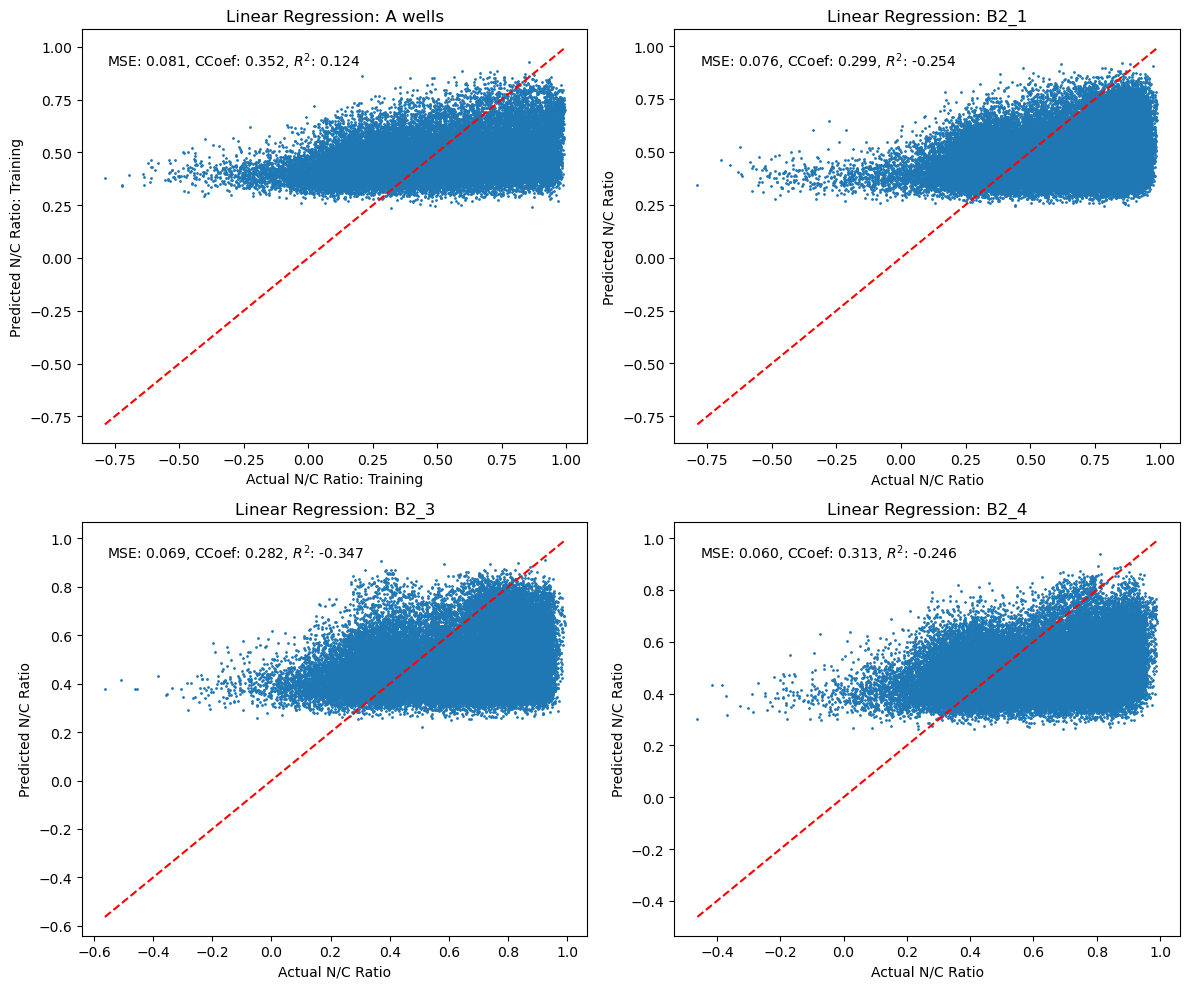

In [27]:
fname = f'LassoABwellsVAEfeatures_trajl{trajl}CC'
# scaler_lr = StandardScaler() # Scale features with Zero Mean & Unit Variance
scaler_lr = MinMaxScaler() # Scale features in the range [0, 1]

#init_alphas = np.array([0.45, 0.35, 0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.1, 0.08, 0.05, 0.03, 1e-2, 1e-3, 0.2e-4]) # JC features params
#init_alphas = np.array([0.53, 0.45, 0.35, 0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.1, 0.08, 0.05, 0.03, 1e-2, 1e-3, 0.5e-4]) # VAE features params 
init_alphas = np.array([0.45, 0.35, 0.23, 0.21, 0.19, 0.17, 0.15, 0.13, 0.1, 0.08, 0.05, 0.03, 1e-2, 1e-3, 0.2e-4]) # VAE features params: CC Vals

############## Training & Testing using LASSOCV directly on original features ##############
target_density = 1000; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 10))
axs = axs.flatten()

fovs_indc = [i for i in range(nfovs)]
fovs_indc = np.array(fovs_indc)
fovs_inds_test = np.array([3, 4, 5])
train_fovs = np.setdiff1d(fovs_indc, fovs_inds_test)

X_train = np.zeros((0, X[0].shape[1]))
y_train = np.zeros(0)
for it_fov in train_fovs:
    X_train = np.append(X_train, X[it_fov], axis = 0)
    y_train = np.append(y_train, y[it_fov], axis = 0)
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]
######### Scale All Features in the Same Range #########
X_scaled_train_trim = scaler_lr.fit_transform(X_train_trim)

# Least Absolute Shrinkage and Selection Operator (LASSO)/ElasticCV
pipe = Pipeline([
                ('scaler', MinMaxScaler()), 
                ('linReg', LassoCV(cv=5, 
                #('linReg', ElasticNetCV(cv=5, l1_ratio = [.1, .2, .3, .4, .5, .6, .7, .8, .9],
                                    alphas=init_alphas, 
                                    max_iter=1000000, tol=1e-4, selection='random', n_jobs=-1))
                ])

pipe.fit(X_scaled_train_trim, y_train_trim)
#alphas = pipe.named_steps['linReg'].alphas_ # Get the alphas from the LassoCV object
#best_alpha = pipe.named_steps['linReg'].alpha_ # Get the best alpha from the LassoCV object
#print(f"Best alpha: {best_alpha}, alphas: {alphas}")

y_pred_LR_train = pipe.predict(X_scaled_train_trim) # Training data predictions
mse_train = mean_squared_error(y_train_trim, y_pred_LR_train)
r2_train = r2_score(y_train_trim, y_pred_LR_train) # R^2 Score
corr_coeff_train = np.corrcoef(y_train_trim, y_pred_LR_train)[0, 1]

axs[0].scatter(y_train_trim, y_pred_LR_train, s = 1)
axs[0].plot([y_train_trim.min(), y_train_trim.max()], [y_train_trim.min(), y_train_trim.max()], 'r--') # Best fit line 
axs[0].set_xlabel('Actual N/C Ratio: Training')
axs[0].set_ylabel('Predicted N/C Ratio: Training')
axs[0].set_title('Linear Regression: A wells')
axs[0].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff_train:.3f}, $R^2$: {r2_train:.3f}',
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

data_list = []
data = {'Training: Correlation coefficient': corr_coeff_train, 'R2 Score': r2_train, 'mse': mse_train}
data_list.append(data)

for i, fov in enumerate(fovs_inds_test):
    test_fov = fov
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_scaled_test = scaler_lr.transform(X_test)
    
    y_pred_LR = pipe.predict(X_scaled_test)
    mse_test = mean_squared_error(y_test, y_pred_LR)
    corr_coeff_test = np.corrcoef(y_test, y_pred_LR)[0, 1]
    r2_test = r2_score(y_test, y_pred_LR) # R^2 Score
    
    axs[i+1].scatter(y_test, y_pred_LR, s = 1)
    axs[i+1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Best fit line 
    axs[i+1].set_xlabel('Actual N/C Ratio')
    axs[i+1].set_ylabel('Predicted N/C Ratio')
    axs[i+1].set_title(f'Linear Regression: {fovs[fov]}')
    axs[i+1].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff_test:.3f}, $R^2$: {r2_test:.3f}', 
                  transform=axs[i+1].transAxes, 
                  verticalalignment='top',
                  horizontalalignment='left')
    data = {'Testing: Correlation coefficient': corr_coeff_test, 'R2 Score': r2_test, 'mse': mse_test}
    data_list.append(data)

plt.tight_layout()

with open(f'{fname}.json', 'w') as fout:
    json.dump(data_list, fout, indent=4)
plt.savefig(f'{fname}.png', dpi = 400, bbox_inches='tight')

#plt.show()

## Top Predictive (JC) Feature Indices from LASSOCV on snapshots: [25 31 36 42 43 55 62 77 78 92 93 94]